<a href="https://colab.research.google.com/github/denni-andr/Project-Sleep/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and mounting dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
import os
import re
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
pip install scikeras[tensorflow]  # cpu


In [ ]:
from scikeras.wrappers import KerasClassifier

ModuleNotFoundError: No module named 'scikeras'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Generation
The below code generates 2D images (heatmaps) for all postures for a given person. The second at which the image is taken is randomly fixed at 30 and can be changed.

In [ ]:
'''PERSON=4
SECOND=30

directory = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}"

# Get the list of file names and sort them numerically
file_names = sorted(os.listdir(directory), key=lambda x: int(re.findall(r'\d+', x)[0]))
# Initialize a subplot grid
num_files = len(file_names)
num_cols = 4  # Number of heatmaps per row
num_rows = (num_files + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows), dpi=200)
# Plot each heatmap
for i, file_name in enumerate(file_names):
    if file_name.endswith(".txt"):
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path, sep='\t', header=None).iloc[:,:-1]
        sub = df.iloc[SECOND].values.reshape(64, 32)
        # Calculate subplot index
        row_idx = i // num_cols
        col_idx = i % num_cols
        # Plot heatmap in the appropriate subplot
        sns.heatmap(sub, vmin=0,vmax=1000,ax=axes[row_idx, col_idx],cmap='gray',cbar=False,annot=False, xticklabels=False, yticklabels=False)
# Hide empty subplots
for i in range(num_files, num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].axis('off')
# Adjust layout
plt.tight_layout()
plt.show()'''

# Video Generation
The below code generates a video file for a range of person and posture (at the provided frame rate). The average time for each video is 2 mins.

In [ ]:
'''# Define parameters
PERSONS = range(7, 8)  # Assume 8 persons
POSTURES = range(15, 18)  # Assume 17 postures per person
FRAME_RATE = 1
INPUT_FOLDER = "/content/drive/Shareddrives/Project Sleep/PMD/experiment-i"
OUTPUT_FOLDER = "/content/drive/Shareddrives/Project Sleep/Generated Videos"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Loop through each person and posture
for PERSON in PERSONS:
    for POSTURE in POSTURES:
        # Define directory and output video file name
        directory = f"{INPUT_FOLDER}/S{PERSON}"
        selected_file = f"{POSTURE}.txt"
        file_path = os.path.join(directory, selected_file)
        output_video = f"{OUTPUT_FOLDER}/Video_S{PERSON}_P{POSTURE}.mp4"

        # Read the selected file
        df = pd.read_csv(file_path, sep='\t', header=None).iloc[:,:-1]

        # Create a writer object to write the frames into a video
        writer = imageio.get_writer(output_video, fps=FRAME_RATE)

        # Plot and add each heatmap to the video
        for i in range(len(df)):
            # Extract the heatmap data for the current second
            sub = df.iloc[i].values.reshape(64, 32)

            # Plot the heatmap
            plt.figure(figsize=(4, 6))
            sns.heatmap(sub, vmin=0, vmax=1000, cmap='magma')
            plt.title(f"S{PERSON} - P{POSTURE} at second {i}", fontsize=16)

            # Save the current plot as an image
            temp_image_path = f"temp_image_{i}.png"
            plt.savefig(temp_image_path)
            plt.close()

            # Read the saved image and add it to the video
            image = imageio.imread(temp_image_path)
            writer.append_data(image)

            # Remove the temporary image file
            os.remove(temp_image_path)

        # Close the writer
        writer.close()
        print(f"Video for S{PERSON}-P{POSTURE} created successfully.")
'''

# Generating Image Dataset

16 frames from each video is generated, resulting in 2912 images



In [ ]:
# # Define the range for PERSON and POSTURE
# for PERSON in range(1, 14):
#     for POSTURE in range(1, 15):  # 14 postures for each person

#         # Define directory
#         directory = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}"

#         # Select the file for which you want to generate the video
#         selected_file = f"{POSTURE}.txt"  # Change to the desired filename

#         # Read the selected file
#         file_path = os.path.join(directory, selected_file)
#         df = pd.read_csv(file_path, sep='\t', header=None).iloc[:, :-1]

#         frames=[i for i in range(10,51)]
#         for i in range(16):
#           frame_no=random.choice(frames)
#           frames.remove(frame_no)
#           frame_image = df.iloc[frame_no].values.reshape(64, 32)

#           image_path = f"/content/drive/Shareddrives/Project Sleep/Image Data/{i}S{PERSON}_P{POSTURE}.png"  # Change the path as needed

#           width=32
#           height=64

#           # plt.figure(figsize=(width / plt.rcParams['figure.dpi'], height / plt.rcParams['figure.dpi']))
#           plt.figure(figsize=(4,6))
#           sns.heatmap(frame_image, vmin=0, vmax=1000, cmap='magma',annot=False,xticklabels=False,yticklabels=False, cbar=False)
#           plt.axis('off')  # Turn off axis
#           plt.savefig(image_path, bbox_inches='tight', pad_inches=0)  # Save without extra whitespace
#           plt.close()

# Label generation


In [3]:
# Define the directory containing the images
image_directory = "/content/drive/Shareddrives/Project Sleep/Image Data"

# List of posture names
posture_names = ['Supine', 'Right', 'Left', 'Right', 'Right', 'Left', 'Left', 'Supine',
                 'Supine', 'Supine', 'Supine', 'Supine', 'Right Fetus', 'Left Fetus']

# Initialize a dictionary to store labels
labels = {}

# Iterate over the files in the directory
for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Ensure the file is an image
        # Extract the posture number from the filename
        posture_number = filename.split("_")[1][1:]  # Assuming the filename format is 'S[number]_P[number]'
        posture_number=int(posture_number[:-4])

        # Assign the corresponding posture name as label
        labels[filename] = posture_names[posture_number - 1]  # Adjust index to start from 0

# Model Building - 2D CNN



In [4]:
image_directory = "/content/drive/Shareddrives/Project Sleep/Image Data"

image_paths = [os.path.join(image_directory, filename) for filename in labels.keys()]
posture_labels = list(labels.values())

images = []
for img_path in image_paths:
    img = load_img(img_path, target_size=(32, 64))  # Resize the images to a common size
    img_array = img_to_array(img) / 255.0
    images.append(img_array)

In [5]:
X = np.array(images)
y = np.array(posture_labels)
x_train, x_val, y_train, y_val = train_test_split(X, posture_labels, test_size=0.3, random_state=42)

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 64 ,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5,activation='softmax')  # Output layer with softmax activation for multiclass classification
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy since the labels are not one-hot encoded
              metrics=['accuracy'])
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [27]:
pred = model.fit(x_train, y_train_encoded, epochs=10, validation_data=(x_val, y_val_encoded))


Epoch 1/10
64/64 [==============================] - 2s 11ms/step - loss: 0.4482 - accuracy: 0.8400 - val_loss: 0.0818 - val_accuracy: 0.9851
Epoch 2/10
64/64 [==============================] - 0s 7ms/step - loss: 0.0162 - accuracy: 0.9961 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 1s 14ms/step - loss: 7.6673e-04 - accuracy: 1.0000 - val_loss: 3.5039e-04 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 1s 8ms/step - loss: 2.6539e-04 - accuracy: 1.0000 - val_loss: 2.1109e-04 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 0s 6ms/step - loss: 1.5367e-04 - accuracy: 1.0000 - val_loss: 1.3974e-04 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 0s 6ms/step - loss: 1.0421e-04 - accuracy: 1.0000 - val_loss: 1.0154e-04 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 0s 8ms/step - loss: 7.5912e-05 - accuracy: 1.0000 - val_loss: 7.5547e-05 -

### Downsampling

In [ ]:
#Downsampling

from sklearn.utils import resample
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
train_data=np.column_stack((x_train_flattened,y_train_encoded))
balanced_data = np.empty((0, train_data.shape[1]), dtype=train_data.dtype)
        # Separate majority and minority classes

majority_class = train_data[train_data[:, -1] == 4]
minority_class = train_data[train_data[:, -1] !=4]
n_samples_to_downsample = min(len(majority_class), len(minority_class))

        # Downsample majority class
majority_downsampled = resample(majority_class,
                                        replace=False,  # sample without replacement
                                        n_samples=n_samples_to_downsample,  # match minority class
                                        random_state=42)  # reproducible results
print(len(majority_downsampled),len(majority_class))
downsampled = np.concatenate([majority_downsampled, minority_class])
balanced_data = np.concatenate([balanced_data, downsampled])
np.random.shuffle(balanced_data)
x_balanced = balanced_data[:, :-1]
# Reshape flattened data back to original shape
x_balanced_reshaped = x_balanced.reshape(x_balanced.shape[0], 32, 64, 3)

y_balanced = balanced_data[:, -1]


882 882


In [ ]:
#Downsampling
pred = model.fit(x_balanced_reshaped, y_balanced, epochs=10, validation_data=(x_val, y_val_encoded))


Epoch 1/10
64/64 [==============================] - 15s 188ms/step - loss: 1.7157e-05 - accuracy: 1.0000 - val_loss: 1.6137e-05 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 8s 132ms/step - loss: 1.3272e-05 - accuracy: 1.0000 - val_loss: 1.2794e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 9s 140ms/step - loss: 1.0782e-05 - accuracy: 1.0000 - val_loss: 1.0745e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 8s 125ms/step - loss: 8.9417e-06 - accuracy: 1.0000 - val_loss: 8.9634e-06 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 5s 81ms/step - loss: 7.6158e-06 - accuracy: 1.0000 - val_loss: 7.7152e-06 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 7s 107ms/step - loss: 6.5300e-06 - accuracy: 1.0000 - val_loss: 6.6838e-06 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 5s 82ms/step - loss: 5.6353e-06 - accuracy: 1.00

### Oversampling


In [ ]:
#Oversampling
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train_flattened, y_train_encoded)

# Stack oversampled data
train_data_oversampled = np.column_stack((x_train_oversampled, y_train_oversampled))

# Shuffle the balanced dataset
np.random.shuffle(train_data_oversampled)

# Separate features and target
x_oversampled = train_data_oversampled[:, :-1]
x_oversampled_reshaped = x_oversampled.reshape(x_oversampled.shape[0], 32, 64, 3)
y_oversampled = train_data_oversampled[:, -1]


In [ ]:
pred = model.fit(x_oversampled_reshaped, y_oversampled, epochs=10, validation_data=(x_val, y_val_encoded))


Epoch 1/10
138/138 [==============================] - 17s 115ms/step - loss: 1.1016e-05 - accuracy: 1.0000 - val_loss: 7.5828e-06 - val_accuracy: 1.0000
Epoch 2/10
138/138 [==============================] - 11s 81ms/step - loss: 6.3057e-06 - accuracy: 1.0000 - val_loss: 4.7360e-06 - val_accuracy: 1.0000
Epoch 3/10
138/138 [==============================] - 12s 86ms/step - loss: 3.9675e-06 - accuracy: 1.0000 - val_loss: 3.0844e-06 - val_accuracy: 1.0000
Epoch 4/10
138/138 [==============================] - 12s 86ms/step - loss: 2.7027e-06 - accuracy: 1.0000 - val_loss: 2.1980e-06 - val_accuracy: 1.0000
Epoch 5/10
138/138 [==============================] - 12s 86ms/step - loss: 1.9280e-06 - accuracy: 1.0000 - val_loss: 1.6630e-06 - val_accuracy: 1.0000
Epoch 6/10
138/138 [==============================] - 12s 87ms/step - loss: 1.4435e-06 - accuracy: 1.0000 - val_loss: 1.3264e-06 - val_accuracy: 1.0000
Epoch 7/10
138/138 [==============================] - 12s 86ms/step - loss: 1.1209e-06 

### Class Weights


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',classes= np.unique(y_train_encoded), y=y_train_encoded)

# Convert class weights to a dictionary
class_weights_dict = dict(zip(np.unique(y_train_encoded), class_weights))


In [ ]:
pred = model.fit(x_train, y_train_encoded,
                 epochs=10,
                 validation_data=(x_val, y_val_encoded),
                 class_weight=class_weights_dict)


Epoch 1/10
64/64 [==============================] - 8s 105ms/step - loss: 0.5691 - accuracy: 0.7610 - val_loss: 0.0604 - val_accuracy: 0.9989
Epoch 2/10
64/64 [==============================] - 6s 86ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 9.1617e-04 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 5s 80ms/step - loss: 7.4127e-04 - accuracy: 1.0000 - val_loss: 2.8300e-04 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 7s 104ms/step - loss: 2.0005e-04 - accuracy: 1.0000 - val_loss: 1.6595e-04 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 5s 82ms/step - loss: 1.0780e-04 - accuracy: 1.0000 - val_loss: 1.0071e-04 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 7s 107ms/step - loss: 6.9395e-05 - accuracy: 1.0000 - val_loss: 6.7137e-05 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 5s 81ms/step - loss: 4.7735e-05 - accuracy: 1.0000 - val_loss: 

# Validating model


In [11]:
test_loss, test_acc = model.evaluate(x_val,y_val_encoded, verbose=2)

28/28 - 0s - loss: 2.2754e-05 - accuracy: 1.0000 - 93ms/epoch - 3ms/step


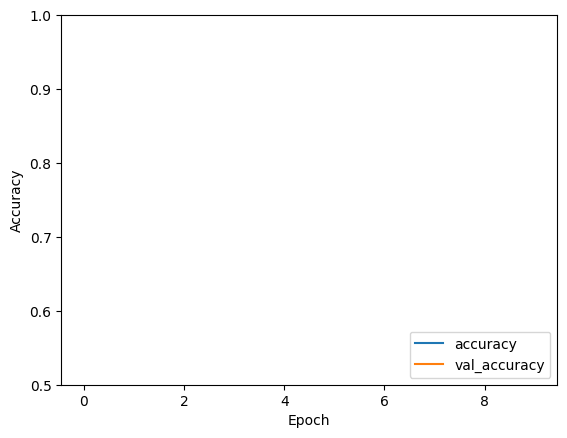

In [21]:
plt.plot(pred.history['accuracy'], label='accuracy')
plt.plot(pred.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Testing model with random images and calculating metrics


In [20]:
image_path = "/content/drive/Shareddrives/Project Sleep/Image Data/0S3_P1.png"

def predict_class(img_array, model):
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

img = load_img(image_path, target_size=(32, 64))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array/=255.0
predicted_class_index = predict_class(img_array, model)

class_names = {0: 'Left', 1: 'Left Fetus', 2:'Right',3:'Right Fetus',4:'Supine'}

predicted_class_name = class_names[predicted_class_index]
print("Predicted class:", predicted_class_name)


1/1 [==============================] - 0s 36ms/step
Predicted class: Left


In [ ]:

# Function to extract the true label from the image filename
def extract_true_label(filename):
    # Extracting the number from the filename
    number = int(filename.split("_P")[1].split(".")[0])
    return posture_names[number - 1]

# Function to predict the class of an image
def predict_class(img_array, model):
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

# Path to the directory containing images
image_dir = "/content/drive/Shareddrives/Project Sleep/Image Data/"

# Load the model
# Assuming you have already loaded your CNN model and stored it in a variable called 'model'

# List to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each image file in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        image_path = os.path.join(image_dir, filename)

        # Load and preprocess the image
        img = load_img(image_path, target_size=(32, 64))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Predict the class of the image
        predicted_class_index = predict_class(img_array, model)

        # Extract the true label from the filename
        true_label = extract_true_label(filename)

        # Store the true label and predicted label
        true_labels.append(true_label)
        predicted_labels.append(class_names[predicted_class_index])

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 24ms/step
Confusion Matrix:
 [[ 624    0    0    0    0]
 [   0  208    0    0    0]
 [   0    0  624    0    0]
 [   0    0    0  208    0]
 [   0    0    0    0 1248]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


# Hyperparameter Tuning


In [ ]:
!pip install --upgrade tensorflow


In [ ]:
 print(tf.__version__)

In [ ]:
def create_model(learning_rates=[0.1,0.01]):

    models = []
    for lr in learning_rates:
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(14, activation='softmax')  # Output layer with softmax activation for multiclass classification
        ])
    # Compile the model
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        models.append(model)
    return models

model = KerasClassifier(build_fn=create_model, verbose=0)
param_grid = {
    'batch_size': [12, 14, 20],
    'epochs': [10, 50, 100]
}
loso_cv = LeaveOneOut()
kfold_cv = KFold(n_splits=5, shuffle=True)
grid_search_loso = GridSearchCV(estimator=model, param_grid=param_grid, cv=loso_cv)
grid_result_loso = grid_search_loso.fit(x_train, y_train_encoded)
best_params_loso = grid_result_loso.best_params_
best_score_loso = grid_result_loso.best_score_
print("Best parameters (LOSO):", best_params_loso)
print("Best score (LOSO):", best_score_loso)

NameError: name 'KerasClassifier' is not defined